# Add Folders to Path

In [1]:
%%time
import sys, os

# get current directory
path = os.getcwd()

# get parent directory
parent_directory = os.path.sep.join(path.split(os.path.sep)[:-2])

# add Algorithm folder to current working path in order to access the functions
sys.path.append(parent_directory+"/Src")

CPU times: user 150 µs, sys: 86 µs, total: 236 µs
Wall time: 176 µs


In [2]:
# Suppress numba warnings arising from computation falling back into object mode.
from numba.core.errors import NumbaDeprecationWarning
import warnings

warnings.simplefilter('ignore', category=NumbaDeprecationWarning)

# Overview

In the following notebok we extract elliptic OECS in the Agulhas region from the AVISO dataset. The notebook is structured as follows:

* Import data from the file 'Agulhas_AVISO.mat' stored in the folder 'Data'
* Define computational parameters (such as the number of cores) and variables
* Define spatio-temporal domain over which to compute the hyperbolic LCS. The spatial domain defines the meshgrid from where to launch the trajectories and the temporal domain specifies the time-interval (in days).
* Interpolate velocity from the gridded data using a cubic spline interpolation
* Compute rate of strain tensor $ \mathbf{S}(\mathbf{x}, t) $ over meshgrid of initial conditions '$ \mathbf{x} $' at time '$t$'
* Compute elliptic OECS as closed null geodesics of $ \mathbf{S}(\mathbf{x}, t)-\mu I $.

# Import Data

In [3]:
%%time
import scipy.io as sio

#Import velocity data from file in data-folder
mat_file = sio.loadmat('../../Data/Agulhas_AVISO.mat')

U = mat_file['u']
V = mat_file['v']
x = mat_file['x']
y = mat_file['y']
time = mat_file['t']

mat_file = sio.loadmat('../../Data/ocean_velocity_example_diffusive.mat')

U = mat_file['vx'].transpose()
V = mat_file['vy'].transpose()
x = mat_file['xc'].transpose()
y = mat_file['yc'].transpose()
time = mat_file['time'].transpose()

CPU times: user 31.7 ms, sys: 13.7 ms, total: 45.4 ms
Wall time: 44.2 ms


# Data/Parameters for Dynamical System

In [4]:
import numpy as np

# number of cores to be used for parallel computing
Ncores = 40

# periodic boundary conditions
periodic_x = False
periodic_y = False
Periodic = [periodic_x, periodic_y]

## compute meshgrid of dataset
X, Y = np.meshgrid(x, y)

# list of parameters
params_data = {"X": X, "Y": Y, "Time": time, "U": U, "V": V, "Ncores": Ncores, "Periodic": Periodic}

# Spatio-Temporal Domain of Dynamical System

In [5]:
%%time
# Time
t_OECS = 0

# store time in array
time = np.array([t_OECS])

# domain boundaries (in degrees)
xmin = -2.5
xmax = 0.5
ymin = -30
ymax = -28

# spacing of meshgrid (in degrees)
dx = 0.01
dy = 0.01

x_domain = np.arange(xmin, xmax + dx, dx)
y_domain = np.arange(ymin, ymax + dy, dy)

# meshgrid of domain
X_domain, Y_domain = np.meshgrid(x_domain, y_domain)

# Define parameters
params_DS = {"time": time, "X_domain": X_domain, "Y_domain": Y_domain}

# Initialize Dynamical System
from ipynb.fs.defs.DynamicalSystem import *

DS = Dynamical_System(params_data, params_DS)

CPU times: user 106 ms, sys: 31.5 ms, total: 137 ms
Wall time: 136 ms


# Interpolate Velocity

In order to evaluate the velocity field at arbitrary locations and times, we must interpolate the discrete velocity data. The interpolation with respect to time is always linear. The interpolation with respect to space can be chosen to be "cubic" or "linear". In order to favour a smooth velocity field, we interpolate the velocity field in space using a cubic interpolant.

In [6]:
%%time
# Interpolate velocity data using linear spatial interpolation
DS._Interpolation_velocity("cubic")

CPU times: user 33.8 ms, sys: 4.63 ms, total: 38.5 ms
Wall time: 37.6 ms


# Rate of strain tensor over meshgrid of initial conditions

The rate of strain tensor $ S(\mathbf{x}, t) $ at time $ t $ is computed by iterating over meshgrid. The method *DS._spin_tensor(x, t)* computes the rate of strain tensor at point $ \mathbf{x} $  at time $ t $ by using an auxiliary meshgrid. 'aux_grid' specifies the ratio between the auxiliary grid and the original meshgrid. This parameter is generally chosen to be between $ [\dfrac{1}{10}, \dfrac{1}{100}] $. The computations are parallelized.

In [7]:
%%time
from tqdm.notebook import tqdm
from joblib import Parallel, delayed

# Define ratio of auxiliary grid spacing vs original grid_spacing
aux_grid = 0.1 # [1/10, 1/100]

def parallel(i):
    
    S_ = np.zeros((X_domain.shape[1], 2, 2))
    
    for j in range(S_.shape[0]):
        
        x = np.array([X_domain[i,j], Y_domain[i,j]])
        
        # Compute rate of strain at 'x'
        S_[j, :, :] = DS._spin_tensor(x, time, aux_grid)
    
    return S_

S = np.array(Parallel(n_jobs=Ncores, verbose = 0)(delayed(parallel)(i) for i in tqdm(range(X_domain.shape[0]))))

  0%|          | 0/202 [00:00<?, ?it/s]

CPU times: user 2.63 s, sys: 1.64 s, total: 4.27 s
Wall time: 6.56 s


# Compute Tensorfield Properties

We now compute the properties of the rate of strain tensor 'S' such as the eigenvalues 's1', 's2' and eigenvectors 'eigenv1', 'eigenv2'. Furthermore, we also need the spatial derivatives of the elements of 'S'.

In [8]:
from ipynb.fs.defs.tensorfield import _tensorfield

# Compute tensorfield properties
s1, s2, eigenv1, eigenv2, S11, S12, S22, S11x, S11y, S12x, S12y, S22x, S22y = _tensorfield(X_domain, Y_domain, S, aux_grid, type = 'OECS')

# Interpolate $ \dot{\phi}(x, y, \phi)$ 

In [12]:
%%time
from ipynb.fs.defs.phi_prime import _phi_prime

# Interpolant phi_phrime, interpolant indicating domain of existence (= denominator of phi_prime)
interp_phi_prime, interp_DOE = _phi_prime(X_domain, Y_domain, S11, S12, S22, S11x, S11y, S12x, S12y, S22x, S22y)

CPU times: user 677 ms, sys: 2.7 s, total: 3.37 s
Wall time: 194 ms


# Find closed null-geodesics of $ S − \mu I $

Elliptic OECSs are closed null geodesics of the one-parameter family of Lorentzian metrics $ S(\mathbf{x}, t) − \mu $. $ \mu ∈ \mathbb{R} $ denotes the tangential stretch rate along an elliptic OECS. For perfectly coherent elliptic OECS with no tangential stretchin (=filamentation) it holds that $ \mu = 0 $.  

In [ ]:
%%time
from ipynb.fs.defs.closed_null_geodesics import _closed_null_geodesics
from ipynb.fs.defs.outermost_elliptic_OECS import _outermost_elliptic_OECS


# define mu range
mu_min = -0.01
mu_max = 0.01
n_mu = 10
mu_range = np.linspace(mu_min, mu_max, n_mu)

# threshold distance for periodicity of trajectory
d_threshold = dx/2

# parameter specifying sparsity of initial conditions. 
# Increasing this parameter reduces the number of initial conditions and thereby reduces the computational time involved.
# For maximal accuracy set sparse_ic = 1. This implies that we use the resolution of the meshgrid. 
# This value should always be at least 1.
sparse_ic = 1

# compute Elliptic OECS
# If you do not want to use parallel computing, then set n_jobs = 1
elliptic_OECS = []

# Initial conditions of mu
init_mu_range = []

for mu in mu_range:
    
    print("Compute elliptic OECS for mu =", np.around(mu, 3))
    
    # Define list storing x, y coordinates of elliptic OECS
    x_elliptic, y_elliptic = [], []
    
    # Find all closed null geodesics
    closed_null_geodesics, init_mu = _closed_null_geodesics(X_domain, Y_domain, mu, interp_phi_prime, d_threshold, S11, interp_DOE, sparse_ic, Ncores)
    
    # Append initial conditions to list 
    init_mu_range.append(init_mu) 
    
    import matplotlib.pyplot as plt
    fig = plt.figure()
    ax = plt.axes()
    for v in closed_null_geodesics:
        if v[0] is not None:
            ax.plot(v[0], v[1])
    plt.show()
        
    # Extract outermost closed null geodesics
    outermost_elliptic_OECS = _outermost_elliptic_OECS(closed_null_geodesics)
    
    # Store outermost closed null geodesics in list
    if outermost_elliptic_OECS:
        
        for elliptic in outermost_elliptic_OECS:
            
            x_elliptic.append(elliptic[0])
            y_elliptic.append(elliptic[1])
            
    elliptic_OECS.append([x_elliptic, y_elliptic])
    

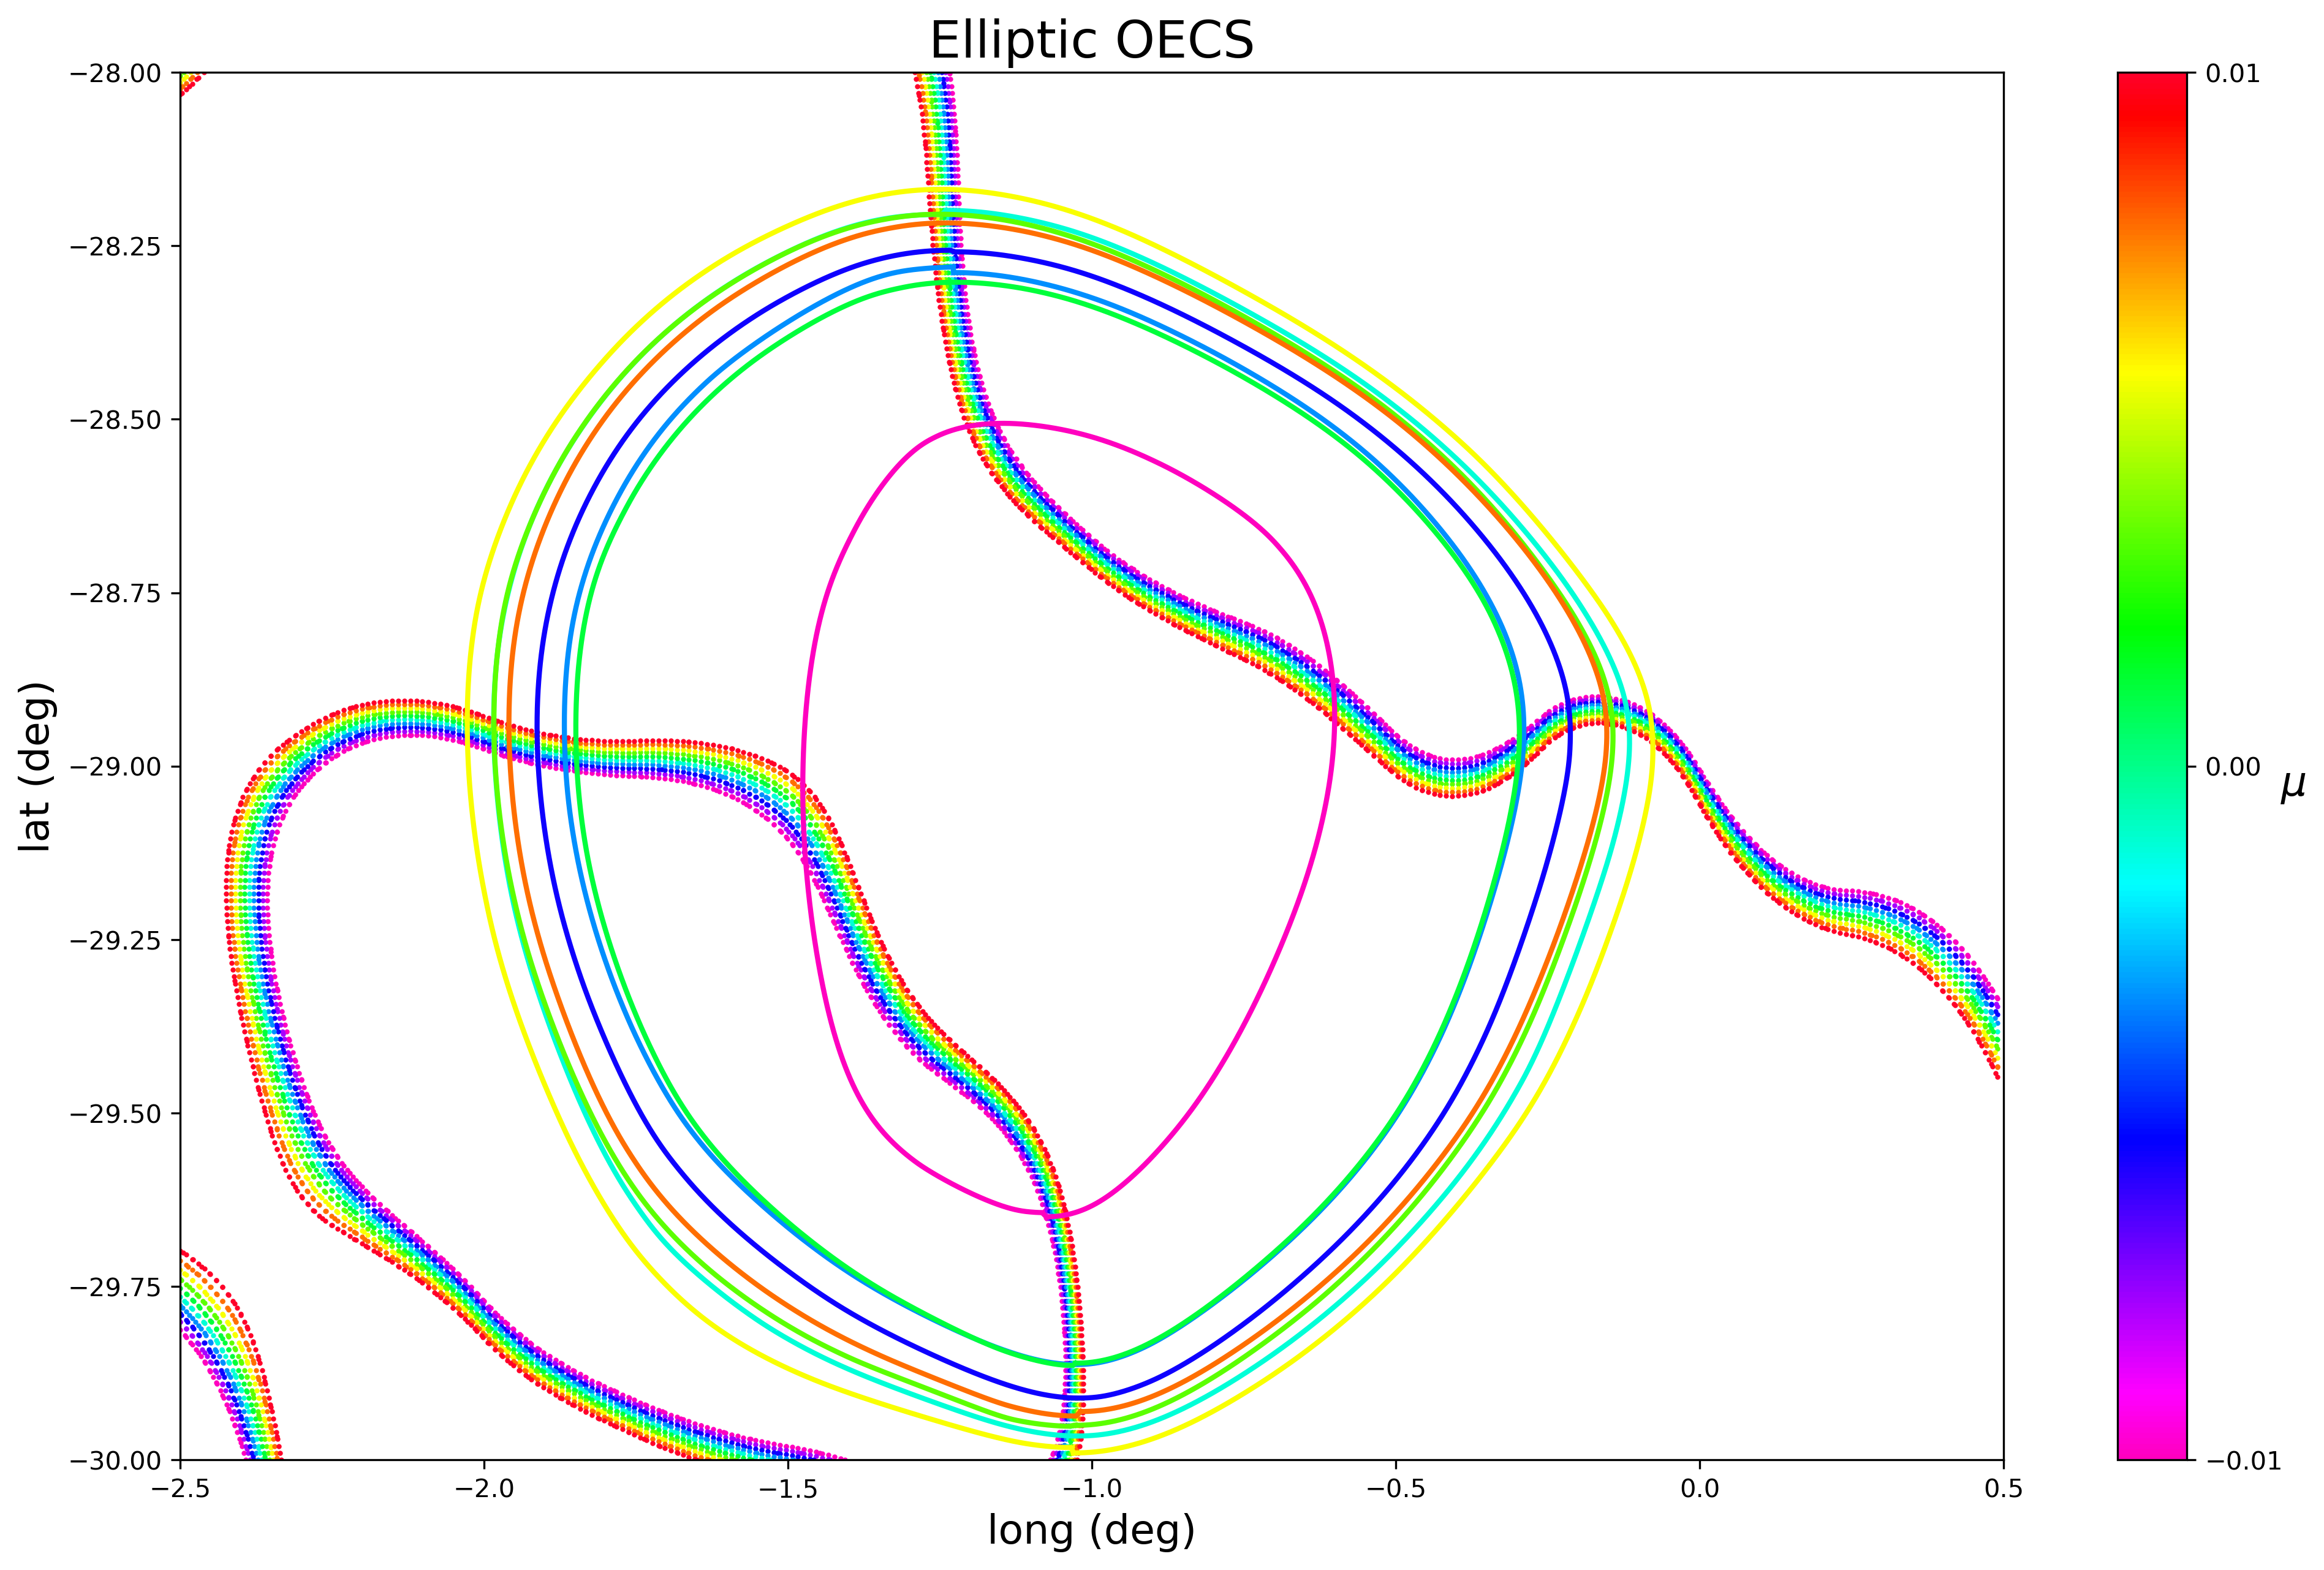

In [11]:
######################################## Plot elliptic OECS ########################################

# import plotting library
import matplotlib.pyplot as plt
import matplotlib as mpl

# Define figure/axes
fig = plt.figure(figsize = (16, 10), dpi = 300)
ax = plt.axes()

# Define norm/cmap
norm = mpl.colors.Normalize(vmin=mu_range.min(), vmax=mu_range.max())
cmap = mpl.cm.ScalarMappable(norm=norm, cmap='gist_rainbow_r')#mpl.cm.jet)

# Iterate over all elliptic OECS and plot
for i in range(len(elliptic_OECS)):
    
    ax.scatter(init_mu_range[i][0], init_mu_range[i][1], s = 1, color=cmap.to_rgba(mu_range[i]))
    
    for j in range(len(elliptic_OECS[i][0])):
        
        if elliptic_OECS[i][0][j] is not None:
        
            ax.plot(elliptic_OECS[i][0][j], elliptic_OECS[i][1][j], c=cmap.to_rgba(mu_range[i]), linewidth = 2)

# Set axis limits
ax.set_xlim([xmin, xmax])
ax.set_ylim([ymin, ymax])

# Set axis labels
ax.set_xlabel("long (deg)", fontsize = 16)
ax.set_ylabel("lat (deg)", fontsize = 16)

# Colorbar
cbar = fig.colorbar(cmap, ticks=[mu_range.min(), 0, mu_range.max()])
cbar.ax.set_ylabel(r'$ \mu $', rotation = 0, fontsize = 16)

# Title
ax.set_title("Elliptic OECS", fontsize = 20)
plt.show();